# Surplus unit allocation

In this project, our goal is to identify the ideal surplus quantity to be added to the demand forecast of each product within the production plan, aiming to maximize profit margins. For each product, we are provided with several key pieces of data: estimated demand, the distribution reflecting demand variability, the margin per unit (calculated as net price minus cost), the cost of goods sold (COGS) representing production costs, capacity constraints (defined as the maximum percentage of demand that can be added as surplus), and a substitutability group number that indicates which products can be substituted for one another. The calculation of actual sales will proceed as follows:

$$
Target Demand_p = Demand_p \times \overline{DemandVar_p}
$$

### Product Demand Example Data

| Product | Demand | Variance group | Margin | COGS | Capacity | Substitutability group |
|---------|--------|-----------------|--------|------|----------|------------------------|
| P1      | 100    | 2               | 165    | 40   | -        | 1                      |
| P2      | 10     | 5               | 140    | 50   | 0        | 1                      |
| P3      | 20     | 2               | 130    | 20   | <=15%    | 1                      |
| P4      | 50     | 3               | 170    | 40   | <=15%    | 2                      |
| P5      | 100    | 3               | 160    | 45   | -        | 2                      |
| P6      | 50     | 1               | 190    | 50   | -        | 2                      |
| ...     | ...    | ...             | ...    | ...  | ...      | ...                    |

### Distribution Parameters for Demand Variance Groups

| Demand Var Group | Distribution | c   | d   | loc | scale |
|------------------|--------------|-----|-----|-----|-------|
| 0                | burr12       | 2   | 25  | -0  | 7     |
| 1                | burr12       | 2   | 4   | 0   | 2     |
| 2                | burr12       | 3   | 4   | 0   | 2     |
| 3                | burr12       | 4   | 2   | 0   | 2     |
| 4                | burr12       | 3   | 2   | 0   | 1     |
| 5                | burr12       | 9   | 1   | -1  | 2     |

The project must adhere to the following constraints to ensure optimal surplus allocation:
- The surplus quantity added to each product's demand must not surpass its designated capacity limit.
- The aggregate surplus quantity across all products should not exceed the total demand for all products, adjusted by a macro target percentage. This macro target percentage is an adjustable input parameter, ranging between 10% and 50%.
- For products classified within the same substitutability group, it's important to maintain adequate total surplus quantities. This approach aims to mitigate the risk of lost sales by leveraging the substitutability of products within these groups, ensuring that demand can be met even if specific products are over or undersupplied.

### Additional Hints:

- As you could see the concept of “substitutability” has been defined very loosely (intentionally) in the problem definition. Often in real-world scenarios, business requirements might not be explicitly clear. For this assignment, understand that the business has indicated products within the same substitutability group can be presented to customers as alternatives to their initial product preference. It's up to you to decide how to approach this scenario. If you think you need to introduce any assumptions or penalties, feel free to do so!

- The term Margin refers to “Revenue-COGS”, but as you can see in the input COGS has been provided separately in case you may need to include that in your formulation of the problem.
 
- For burr12 distribution you can use “scipy.stats.burr12” from the SciPy library.

- If capacity is "-", it means that there is no capacity or upper-bound defined for them.
- Adequate, means that we need to produce enough so that we have enough units based on the demands for those products, assuming that the products in the same substitutability group can be substituted. Meaning if you don’t have enough of customer’s first choice, you can offer them another product from the same group.

### Assumptions and Notes (for the Provided Solution):
- The model assumes that uncertain parameters have independent probability distribution functions.
- The model assumes that demand quantities are integer in the deterministic case, but for the sake of simplicity variables can be relaxed to be continuous if it doesn't harm the accuracy from the clien't perspective. We can also improve the IP performance by using better solvers, applying a heuristic or warm start for finding initial solutions, implementing decomposition methods, or even by grouping similar customers (e.g., by a clustering method) to reduce the size of the problem!

- Pyomo was selected for developing the optimization model due to its user-friendly nature and efficient performance compared with other free open-source libraries such as PuLP and SciPy optimize.
- The solver used in the model is glpk, which is a free solver. However, commercial solvers such as CPLEX, Gurobi, and FICO Xpress might provide better performance.
- Deterministic equivalent of the stochastic model has been developed, which is by creating samples from PDF of the uncertain parameters.
- The model includes three sampling methods: random sampling, Latin Hypercube Sampling (LHS), and quasi-Monte Carlo (QMC) sampling. LHS and QMC sampling methods generally outperform random sampling, and the user can choose which one to use based on their requirements.
- Note that scenario reduction approches such as scenario tree reduction can be implemented to reduce the number of scenarios while staying accurate enough.
- In the developed deterministic equivalent, objective function is the expected value of the profit. We can also use other methods such as robust optimization or conditional value at risk (CVar) to address uncertainty in the problem.
- Some metrics that can be used at the end to measure the performance of the model include: optimality gap, solve time, optimal profit vs. current state profit, and demand satisfaction monitoring (feasibility of the model in different scenarios).


In [1]:
#install pyDOE for Latin Hypercube Sampling (LHS), install pyomo and glpk (or any other solver) as well

!pip install pyDOE
!pip install pyomo

!conda install -y -c conda-forge glpk

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 24.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#import modules
from modules import data_prep, optimization, post_processing

In [3]:
raw_data = pd.read_excel('data/Input_SUA.xlsx', sheet_name = 'Demand')
var_group_df = pd.read_excel('data/Input_SUA.xlsx', sheet_name = 'Demand Variance')

demand_df = data_prep.data_transformation(raw_data)
demand_df

INFO:root:Performing data transformation...


Unnamed: 0,Demand,Variance group,Margin,COGS,Capacity,Substitutability group,Product_ID
0,5702.0,3.0,167.676111,36.5,0.15,0.0,1
1,58512.0,2.0,180.180292,36.9,0.15,0.0,2
2,12332.0,3.0,120.745153,28.7,NaN,0.0,3
3,8493.0,3.0,95.471966,43.5,0.15,0.0,4
4,68762.0,4.0,245.111234,46.8,NaN,0.0,5
...,...,...,...,...,...,...,...
495,83464.0,1.0,288.887694,50.6,0.15,196.0,496
496,23642.0,4.0,229.070002,33.0,0.15,196.0,497
497,43507.0,5.0,220.883911,46.0,NaN,197.0,498
498,18533.0,2.0,287.841329,47.1,NaN,197.0,499


INFO:root:Performing exploratory data analysis...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Demand                  500 non-null    object
 1   Variance group          500 non-null    object
 2   Margin                  500 non-null    object
 3   COGS                    500 non-null    object
 4   Capacity                276 non-null    object
 5   Substitutability group  500 non-null    object
 6   Product_ID              500 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 27.5+ KB
None
Unnamed: 0  Product_ID
count       500.000000
mean        250.500000
std         144.481833
min           1.000000
25%         125.750000
50%         250.500000
75%         375.250000
max         500.000000


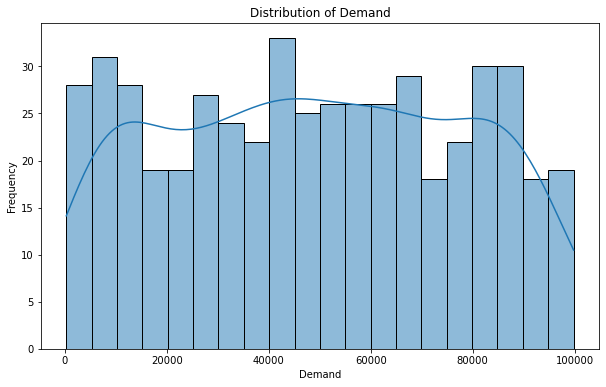

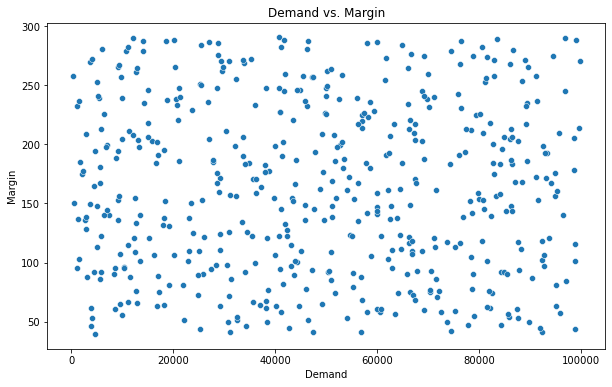

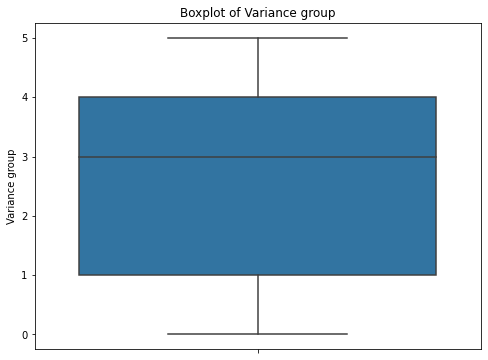

In [4]:
data_prep.exploratory_data_analysis(demand_df)

INFO:root:Visualizing demand distribution...


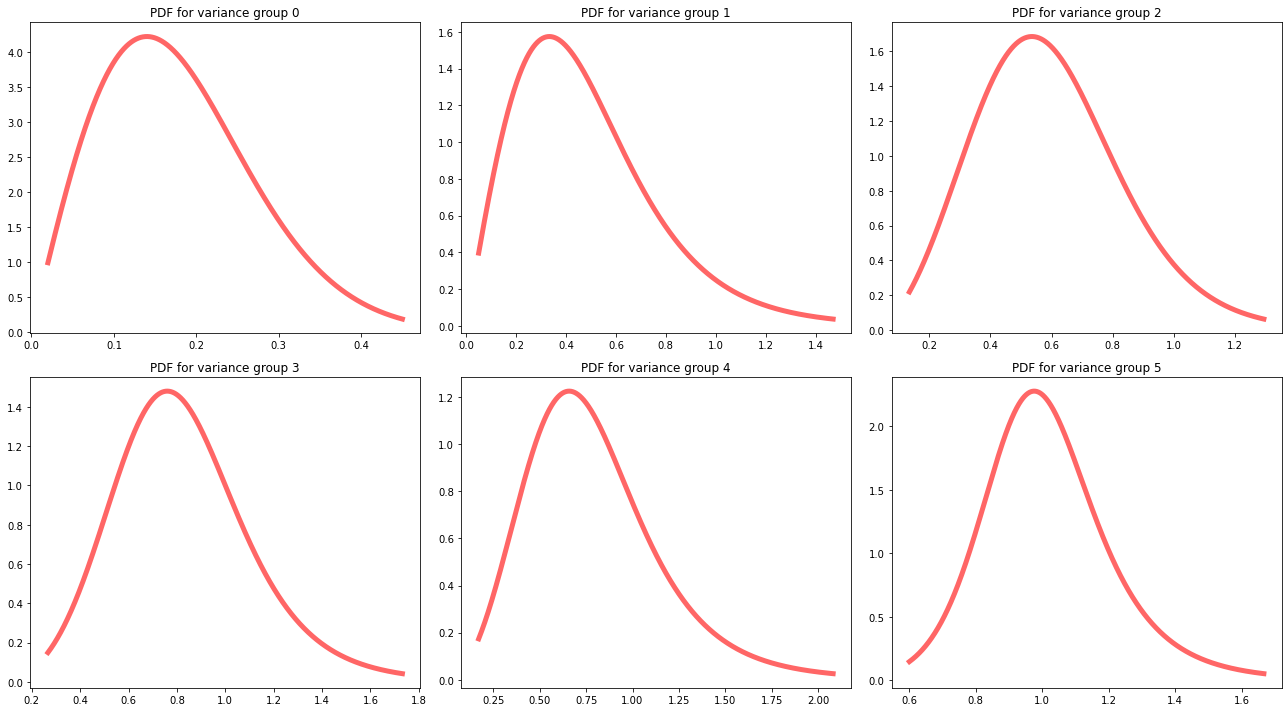

In [5]:
data_prep.demand_dist_visualization(var_group_df)

In [6]:
demand_df = data_prep.feature_engineering(demand_df)
demand_df

INFO:root:Performing feature engineering...


Unnamed: 0,Demand,Variance group,Margin,COGS,Capacity,Substitutability group,Product_ID,Revenue
0,5702.0,3.0,167.676111,36.5,0.15,0.0,1,204.176111
1,58512.0,2.0,180.180292,36.9,0.15,0.0,2,217.080292
2,12332.0,3.0,120.745153,28.7,0.50,0.0,3,149.445153
3,8493.0,3.0,95.471966,43.5,0.15,0.0,4,138.971966
4,68762.0,4.0,245.111234,46.8,0.50,0.0,5,291.911234
...,...,...,...,...,...,...,...,...
495,83464.0,1.0,288.887694,50.6,0.15,196.0,496,339.487694
496,23642.0,4.0,229.070002,33.0,0.15,196.0,497,262.070002
497,43507.0,5.0,220.883911,46.0,0.50,197.0,498,266.883911
498,18533.0,2.0,287.841329,47.1,0.50,197.0,499,334.941329


In [7]:
var_group_df

,Demand Var Group,distribution,c,d,loc,scale
0,0,burr12,2,25,0,7
1,1,burr12,2,4,0,2
2,2,burr12,3,4,0,2
3,3,burr12,4,2,0,2
4,4,burr12,3,2,0,1
5,5,burr12,9,1,-1,2


In [8]:
joint_scenarios_df = data_prep.generate_joint_scenarios(var_group_df, num_scenarios_per_group = 5, random_seed = 777, sampling_method = 'lhs')
joint_scenarios_df

INFO:root:Generating joint scenarios...
INFO:root:Generating individual scenarios...
INFO:root:Generating individual scenarios...
INFO:root:Generating individual scenarios...
INFO:root:Generating individual scenarios...
INFO:root:Generating individual scenarios...
INFO:root:Generating individual scenarios...


,Scenario_ID,demand_var_group0,demand_var_group1,demand_var_group2,demand_var_group3,demand_var_group4,demand_var_group5,joint_probability
0,1.0,1.087336,0.89574,0.774581,0.881530,0.378040,1.033501,0.000099
1,2.0,1.087336,0.89574,0.774581,0.881530,0.378040,0.678016,0.000068
2,3.0,1.087336,0.89574,0.774581,0.881530,0.378040,1.183851,0.000079
3,4.0,1.087336,0.89574,0.774581,0.881530,0.378040,2.154967,0.000004
4,5.0,1.087336,0.89574,0.774581,0.881530,0.378040,0.869467,0.000098
...,...,...,...,...,...,...,...,...
15620,15621.0,1.410883,1.25602,0.401127,1.619139,0.988059,1.033501,0.000048
15621,15622.0,1.410883,1.25602,0.401127,1.619139,0.988059,0.678016,0.000033
15622,15623.0,1.410883,1.25602,0.401127,1.619139,0.988059,1.183851,0.000038
15623,15624.0,1.410883,1.25602,0.401127,1.619139,0.988059,2.154967,0.000002


## Optimization Model Formulation 

### Deterministic Model (IP):

**Decision Variables:**
- $s_i$: Surplus quantity added to the demand forecast for product $i$. This is a non negative integer variable.

**Objective Function:**
Maximize total profit margins:
$$ \text{Maximize} \sum_{i} \text{Margin}_i \cdot (Demand_i + s_i) $$

**Constraints:**
1. Capacity Constraints:
   - For each product $i$, the surplus quantity $s_i$ must not exceed its designated capacity limit, if specified:
     $$ s_i \leq \text{Capacity}_i \cdot \text{Demand}_i \quad \forall i$$

2. Total Surplus Quantity Constraint:
   - The total surplus quantity added to all products' demand forecasts should not exceed the total demand for all products, adjusted by a macro target percentage:
     $$ \sum_{i} s_i \leq (1 + \text{MacroTargetPercentage}) \cdot \sum_{i} \text{Demand}_i $$


**Data:**
- $\text{Margin}_i$: Margin per unit for product $i$.
- $\text{COGS}_i$: Cost of goods sold (production cost) for product $i$.
- $\text{Capacity}_i$: Capacity constraint for product $i$.
- $\text{Demand}_i$: Estimated demand for product $i$.
- $\text{MacroTargetPercentage}$: Macro target percentage for adjusting total surplus quantity.

### Stochastic Model (IP):

**Decision Variables:**
- $s_{iw}$: Surplus quantity added to the demand forecast for product $i$ given scenario $w$

**Objective Function:**
Maximize the expected total profit:
$$ \text{Maximize} \sum_{i}\sum_{w} \text{Probability}_w \cdot \text{Margin}_i \cdot (TargetDemand_{iw} \cdot s_{iw}) $$

**Constraints:**
1. Capacity Constraints:
   - For each product $i$ and scenario $w$, the surplus quantity $s_{iw}$ must not exceed its designated capacity limit, if specified:
     $$ s_{iw} \leq \text{Capacity}_i \cdot \text{TargetDemand}_{iw} \quad \forall w, i$$

2. Total Surplus Quantity Constraint:
   - For each scenario $w$, the total surplus quantity added to all products' demand forecasts should not exceed the total demand for all products, adjusted by a macro target percentage:
     $$ \sum_{i} s_{iw} \leq (1 + \text{MacroTargetPercentage}) \cdot \sum_{i} \text{TargetDemand}_{iw} \quad \forall w $$
     
3. Maintaining adequate total surplus quantities for products classified within the same substitutability group:

    $$ \sum_{i \in SG_k} Demand_i + s_{iw} \geq \sum_{i \in SG_k} \text{TargetDemand}_{iw} \quad \forall w, k$$ 
   
   Note that each $SG_k$ refers to a group of mutually substitutable products (assuming we have k groups/clusters of products that within each group product are mutually substitutable). Also, this set of constraints are only included in the stochastic model because we have two parameters for demand: 1) $Demand_i$, and 2) $TargetDemand_i$. Here the latter is the realized value of the former (predicted parameter).
   
**Note**
- The model is Integer Programming (IP) model because quantity is assumed to be integer from the input file, but definitely relaxing it to Linear Programming (LP) improves the performance in case this relaxation is acceptable.
- The stochastic version of the model has an additional index $w$ which refers to the scenarios that are created.
- Since COGS is also given, we can have an optional additional constraint to include a budget constraint, too. But since this is a profit maximization problem, we can leave that out for now.

In [9]:
%%time
deterministic_optimization_results_df, profit, *remaining = optimization.run_deterministic_optimization(demand_df, macroTargetPercentage = 0.20, solver_name = 'glpk')
deterministic_optimization_results_df, profit

INFO:root:Solve Started.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpkv1tzhlp.glpk.raw
 --wglp /var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpd49hryjr.glpk.glp
 --cpxlp /var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpqk6xif23.pyomo.lp
Reading problem data from '/var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpqk6xif23.pyomo.lp'...
501 rows, 501 columns, 1000 non-zeros
500 integer variables, none of which are binary
4015 lines were read
Writing problem data to '/var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpd49hryjr.glpk.glp'...
3508 lines were written
GLPK Integer Optimizer 5.0
501 rows, 501 columns, 1000 non-zeros
500 integer variables, none of which are binary
Preprocessing...
Objective value =   5.146183316e+09
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.4 Mb (439124 bytes)
Writing MIP solution to '/var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpkv1tzhl

(     Surplus
 1      855.0
 2     8776.0
 3     6166.0
 4     1273.0
 5    34381.0
 ..       ...
 496  12519.0
 497   3546.0
 498  21753.0
 499   9266.0
 500  26210.0
 
 [500 rows x 1 columns],
 5146183315.575935)

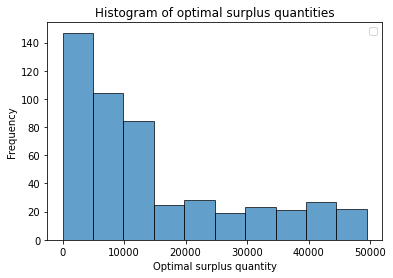

In [10]:
post_processing.visualize_results(deterministic_optimization_results_df, demand_df)

In [11]:
##Prepare data for stochastic optimization
target_demand_df = data_prep.create_target_demands(demand_df, joint_scenarios_df)
target_demand_df

,Scenario_ID,Product_ID,target_demand
0,1.0,1,5026.486176
1,1.0,2,45322.262874
2,1.0,3,10871.032536
3,1.0,4,7486.837442
4,1.0,5,25994.769872
...,...,...,...
7811995,15624.0,496,104832.4691
7811996,15624.0,497,23359.683891
7811997,15624.0,498,37827.909196
7811998,15624.0,499,7434.083377


In [12]:
%%time
stochastic_optimization_results_df, profit, *remaining = optimization.run_stochastic_optimization(demand_df, joint_scenarios_df, target_demand_df, macroTargetPercentage = 0.20, solver_name = 'glpk')
stochastic_optimization_results_df, profit

INFO:root:Solve Started.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpnpx71f0u.glpk.raw
 --wglp /var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmp34sco8iq.glpk.glp
 --cpxlp /var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpkiniutg1.pyomo.lp
Reading problem data from '/var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpkiniutg1.pyomo.lp'...
7828125 rows, 7812500 columns, 15625000 non-zeros
54734384 lines were read
Writing problem data to '/var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmp34sco8iq.glpk.glp'...
54718753 lines were written
GLPK Simplex Optimizer 5.0
7828125 rows, 7812500 columns, 15625000 non-zeros
Preprocessing...
~     0: obj =   1.319653304e+09  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   7.6 secs
Memory used: 6490.3 Mb (6805611028 bytes)
Writing basic solution to '/var/folders/9t/rjzn0p2x6359p_qwm1_7tbvh0000gn/T/tmpnpx71f0u.glpk.raw'...
15640634 lines were written
CPU

(                             Surplus
 Scenario_ID Product_ID              
 1.0         1             753.972926
 2.0         1             753.972926
 3.0         1             753.972926
 4.0         1             753.972926
 5.0         1             753.972926
 ...                              ...
 15621.0     500         10513.734546
 15622.0     500         10513.734546
 15623.0     500         10513.734546
 15624.0     500         10513.734546
 15625.0     500             0.000000
 
 [7812500 rows x 1 columns],
 1319653304.4597178)

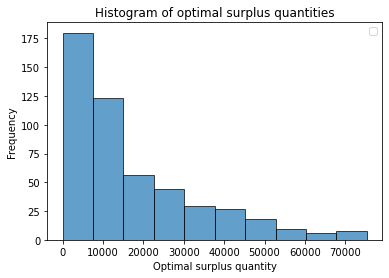

In [14]:
plt.hist(stochastic_optimization_results_df.groupby('Product_ID').mean()['Surplus'], edgecolor='black', alpha=0.7)

plt.title("Histogram of optimal surplus quantities")
plt.xlabel("Optimal surplus quantity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Output Evaluation

### Solve Time
Implementing stochastic optimization and solving the deterministic equivalent (although it was relaxed to LP) led to a significant increase in solve time, from a total of 86.5 ms to 12 minutes and 53 seconds, when transitioning from the deterministic to the stochastic model.

### Profit
The deterministic model yielded an optimal profit of 5.15 billion dollars, whereas the stochastic model reduced this figure to \$1.32 billion. This reduction underscores the stochastic model's ability to provide more realistic outcomes.

### Strategy
Analysis of the optimal surplus quantity distribution reveals that the stochastic model compared with the deterministic model opted to increase the surplus quantity for some products while decreasing it for others.

### Potential Improvements
- Conduct sensitivity analysis on parameters such as capacities or margins.
- Enhance the model's performance.
- Extract deeper insights based on variance groups.
